In [40]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

from itertools import product
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from typing import Literal

from matplotlib import gridspec
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle

# Figure 1

In [52]:
def hamming_dist(string_1, string_2):
    return sum(c1 != c2 for c1, c2 in zip(string_1, string_2))

def get_equidistant_points(radius, num_points, ):
    points = []
    for i in range(num_points):
        angle_degrees = (360 / num_points) * i 
        x = radius * math.cos(math.radians(angle_degrees))
        y = radius * math.sin(math.radians(angle_degrees))
        points.append((x, y))
    return points

def radial_plot(
        radius: int,
        regime: Literal['interpolation', 'extrapolation'],
        seed: int = 0, 
        extrapolation_index: int =5, 
        gray_out: list = [5]):
    
    # fix random seed
    np.random.seed(seed)

    # set sequences
    seed_seq = "AAAAAA"
    alphabet = "ABC"
    orig_seq_ls = [''.join(i) for i in product(alphabet, repeat = 6)]
    seq_ls = []
    neighbourhood_ls = []
    for length in range(len(seed_seq) + 1):
        neighbours = []
        for seq in orig_seq_ls:
            if hamming_dist(seed_seq, seq) == length:
                neighbours.append(seq)
        # reduce neighbourhood so graph isnt ugly
        if len(neighbours) > 20:
            extra = neighbours[20:]
            to_remove = random.sample(extra, len(extra)//1.5)
            neighbours = neighbours[:20] + [x for x in extra if x not in to_remove]
        seq_ls += neighbours
        neighbourhood_ls.append(neighbours)

    # set test or train
    signal = []
    for seq in seq_ls:
        if regime == "extrapolation":
            if gray_out != None: 
                
                if hamming_dist(seed_seq, seq) in gray_out:
                    signal.append(2)
                elif hamming_dist(seed_seq, seq) == extrapolation_index:
                    signal.append(1)
                else:
                    signal.append(0)
        elif regime == "interpolation":
            # i.e. 25 pct test split
            if gray_out!=None:
                if hamming_dist(seed_seq, seq) in gray_out:
                    signal.append(2)
                    
                elif np.random.random(1) > 0.75:
                    signal.append(1)
                else:
                    signal.append(0)

    # make adjacency matrix
    adjacency_matrix = np.zeros((len(seq_ls), len(seq_ls)), dtype="int8")
    for i in range(len(seq_ls)):
        for j in range(i):
            if j == i:
                continue
            elif hamming_dist(seq_ls[i], seq_ls[j]) == 1:
                adjacency_matrix[i][j] = 1
                adjacency_matrix[j][i] = 1

    # make graph
    graph = nx.from_numpy_array(adjacency_matrix)
    for idx, node in enumerate(graph.nodes()):
        graph.nodes[node]['seq'] = seq_ls[idx]
        graph.nodes[node]["signal"] = signal[idx]

    # make graph radial
    current_radius = 0
    position_dict = {}
    for neighbourhood in neighbourhood_ls:
        neighbourhood_positions = get_equidistant_points(
            current_radius,
            len(neighbourhood)
        )
        current_radius += radius
        for idx, sequence in enumerate(neighbourhood):
            position_dict[sequence] = neighbourhood_positions[idx]

    for node in graph.nodes():
        try:
            graph.nodes[node]["pos"] = position_dict[graph.nodes[node]["seq"]]
        except:
            pass
    return graph

In [53]:
nk_extrap = pd.read_csv("../results/ohe/extrapolation_results_NK.csv")


nk_extrap_single_idx = {"K": [], "Model": [], "Pearson_corr": []}
nk_extrap_double_idx = {"K": [], "Model": [], "Pearson_corr": []}
nk_extrap_triple_idx = {"K": [], "Model": [], "Pearson_corr": []}
nk_extrap_quad_idx = {"K": [], "Model": [], "Pearson_corr": []}
nk_extrap_pent_idx = {"K": [], "Model": [], "Pearson_corr": []}
nk_interp_idx = {"K": [], "Model": [], "Pearson_corr": []}


model_list = ['linear', 'rf', 'gb', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer']
model_names = ['Linear', 'RF', 'GB', 'MLP', 'CNN', 'uLSTM', 'bLSTM', 'Transformer']

for k in range(6):

    # iterate through model type
    for model_number, model in enumerate(model_list):

        # get df
        extrap_df = nk_extrap[(nk_extrap['model'] == model) & (nk_extrap['landscape'] == f"k{k}")]
        train_regimes = list(extrap_df["train_regime"].unique())
        train_regimes.sort()

        # training data
        for i, max_train_dist in enumerate(train_regimes):

            # extrapolation would require Mi where i is greater than the range of train dist
            extrap_regimes = [f"M{i + 1}" for i in range(int(max_train_dist[-1]), 6)]
            interp_regimes = [f"M{i + 1}" for i in range(6) if i + 1 <= int(max_train_dist[-1])]
            
            # test on single mutation extrapolation
            if len(extrap_regimes) > 0:
                df = extrap_df[(extrap_df["train_regime"] == max_train_dist) & (extrap_df["test_data"] == extrap_regimes[0])]
                nk_extrap_single_idx["K"] += [k] * len(df)
                nk_extrap_single_idx["Model"] += [model_names[model_number]] * len(df)
                nk_extrap_single_idx["Pearson_corr"] += df.pearson_r.tolist()
            
            if len(extrap_regimes) > 1:
                df = extrap_df[(extrap_df["train_regime"] == max_train_dist) & (extrap_df["test_data"] == extrap_regimes[1])]
                nk_extrap_double_idx["K"] += [k] * len(df)
                nk_extrap_double_idx["Model"] += [model_names[model_number]] * len(df)
                nk_extrap_double_idx["Pearson_corr"] += df.pearson_r.tolist()
            
            if len(extrap_regimes) > 2:
                df = extrap_df[(extrap_df["train_regime"] == max_train_dist) & (extrap_df["test_data"] == extrap_regimes[2])]
                nk_extrap_triple_idx["K"] += [k] * len(df)
                nk_extrap_triple_idx["Model"] += [model_names[model_number]] * len(df)
                nk_extrap_triple_idx["Pearson_corr"] += df.pearson_r.tolist()
            
            if len(extrap_regimes) > 3:
                df = extrap_df[(extrap_df["train_regime"] == max_train_dist) & (extrap_df["test_data"] == extrap_regimes[3])]
                nk_extrap_quad_idx["K"] += [k] * len(df)
                nk_extrap_quad_idx["Model"] += [model_names[model_number]] * len(df)
                nk_extrap_quad_idx["Pearson_corr"] += df.pearson_r.tolist()

            if len(extrap_regimes) > 4:
                df = extrap_df[(extrap_df["train_regime"] == max_train_dist) & (extrap_df["test_data"] == extrap_regimes[4])]
                nk_extrap_pent_idx["K"] += [k] * len(df)
                nk_extrap_pent_idx["Model"] += [model_names[model_number]] * len(df)
                nk_extrap_pent_idx["Pearson_corr"] += df.pearson_r.tolist()

            for j, test_dist in enumerate(interp_regimes):
                df = extrap_df[(extrap_df["train_regime"] == max_train_dist) & (extrap_df["test_data"] == test_dist)]
                nk_interp_idx["K"] += [k] * len(df)
                nk_interp_idx["Model"] += [model_names[model_number]] * len(df)
                nk_interp_idx["Pearson_corr"] += df.pearson_r.tolist()

In [54]:
node_kwargs = {
    "cmap": ListedColormap(["#4eb3d3","#e67e5a", "#D3D3D3"]), # train and test colours
    "node_size": 30,
    "linewidths": 1,
    "edgecolors": "black",
}
edge_kwargs = {
    "edge_color": "#474747",
    "width": 1,
    "alpha": 0.1,
}


G_interp = radial_plot(radius=1, regime="interpolation", seed=7, gray_out=[3,4,5])
pos_interp = nx.get_node_attributes(G_interp, 'pos')
signals_interp = np.array([G_interp.nodes[n]['signal'] for n in G_interp.nodes()])

G_ext_1 = radial_plot(radius=1, regime="extrapolation", seed=7, extrapolation_index=3, gray_out=[4,5])
pos_ext_1 = nx.get_node_attributes(G_ext_1, 'pos')
signals_ext_1 = np.array([G_ext_1.nodes[n]['signal'] for n in G_ext_1.nodes()])

G_ext_2 = radial_plot(radius=1, regime="extrapolation", seed=7, extrapolation_index=4, gray_out=[3,5])
pos_ext_2 = nx.get_node_attributes(G_ext_2, 'pos')
signals_ext_2 = np.array([G_ext_2.nodes[n]['signal'] for n in G_ext_2.nodes()])

G_ext_3 = radial_plot(radius=1, regime="extrapolation", seed=7, extrapolation_index=5, gray_out=[3,4])
pos_ext_3 = nx.get_node_attributes(G_ext_3, 'pos')
signals_ext_3 = np.array([G_ext_3.nodes[n]['signal'] for n in G_ext_3.nodes()])


TypeError: can't multiply sequence by non-int of type 'float'

In [45]:
pearson_results = np.zeros((8, 6, 4, 6, 6)) # shape = (n_models, k_vals, replicates, train_distances, test_distances)
#load data 
import pickle 

models = ['linear', 'rf', 'gb', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer']
with open('../results/extrapolation_results_NK.pkl', 'rb') as file: 
    extrap_results = pickle.load(file)
for model_index, model in enumerate(models): 
    for k_index, k_value in enumerate(extrap_results[model].keys()):         
        for repl_index, replicate in enumerate(extrap_results[model][k_value].keys()): 
            for train_index, train_distance in enumerate(extrap_results[model][k_value][replicate].keys()):
                for test_index, test_distance in enumerate(list(extrap_results[model][k_value][replicate][train_distance][0].keys())[1:]):
                    pearson_results[model_index][k_index][repl_index][train_index][test_index] = extrap_results[model][k_value][replicate][train_distance][0][test_distance]['pearson_r']
            

In [46]:
pearson_results_mean = np.nanmean(pearson_results, axis=2)


In [47]:
pearson_results_to_show = pearson_results[]

SyntaxError: invalid syntax (3256234492.py, line 1)

In [48]:
#load data 
with open('../results/ablation_results_NK.pkl', 'rb') as file: 
    abl_results = pickle.load(file)

In [49]:
abl_pearson_results = np.zeros((8,6,4,5))
for model_index, model in enumerate(models): 
    for k_index, k_value in enumerate(abl_results[model].keys()):         
        for repl_index, replicate in enumerate(abl_results[model][k_value].keys()): 
            for density_ind, density in enumerate(abl_results[model][k_value][replicate].keys()): 
                abl_pearson_results[model_index][k_index][repl_index][density_ind] = abl_results[model][k_value][replicate][density][0]['test']['pearson_r']
                

In [50]:
abl_prsn_res_means = np.mean(abl_pearson_results, axis=2)

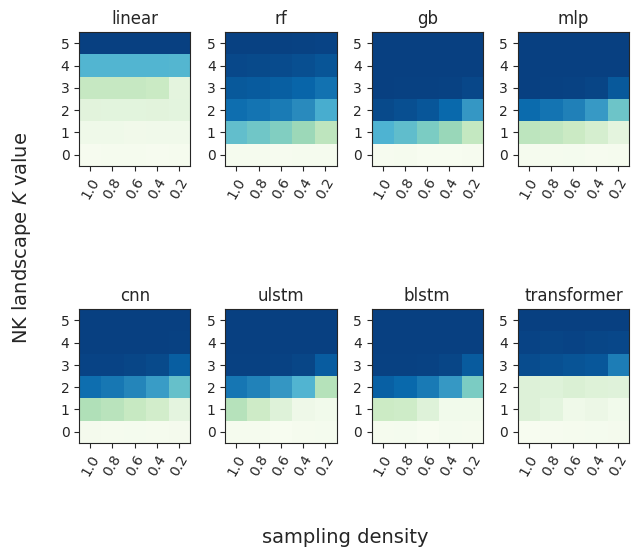

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (6, 6))

#plt.rcParams.update({'axes.spines.top': True, 'axes.spines.right': True})

k=0
for i in range(abl_prsn_res_means.shape[0]):
    if i<4:
        j=0
    else: 
        j=1
    if i==4: 
        k=0    
    
    data = abl_prsn_res_means[i]
    #print(data.shape)
    ax[j,k].imshow(abl_prsn_res_means[i], 
                cmap='GnBu', 
                vmin=np.nanmin(abl_prsn_res_means), 
                vmax=np.nanmax(abl_prsn_res_means))
    ax[j,k].set_title(models[i])
    
    k+=1

#do x-axis labels
#do x-axis labels
x_ticks = [1.0, 0.8, 0.6, 0.4, 0.2]
for col_idx, axis in enumerate(ax.flatten()):
    tick_labels = x_ticks
    axis.set_xticks(range(5))  # Set 6 tick positions
    axis.set_xticklabels(tick_labels, 
                         rotation=60, 
                         fontsize=10)

y_ticks = range(6)
for row_idx, axis in enumerate(ax.flatten()): 
    tick_labels = reversed(y_ticks)
    axis.set_yticks(range(6))
    axis.set_yticklabels(tick_labels, 
                         rotation=0, 
                         fontsize=10)

fig.text(-0.04, 0.5, 
         'NK landscape $K$ value', 
         ha='center', 
         va='center', 
         rotation='vertical', 
         fontsize=14)

fig.text(0.5, -0.0, 
         'sampling density', 
         ha='center',
         va='center', 
         fontsize=14)

fig.tight_layout()

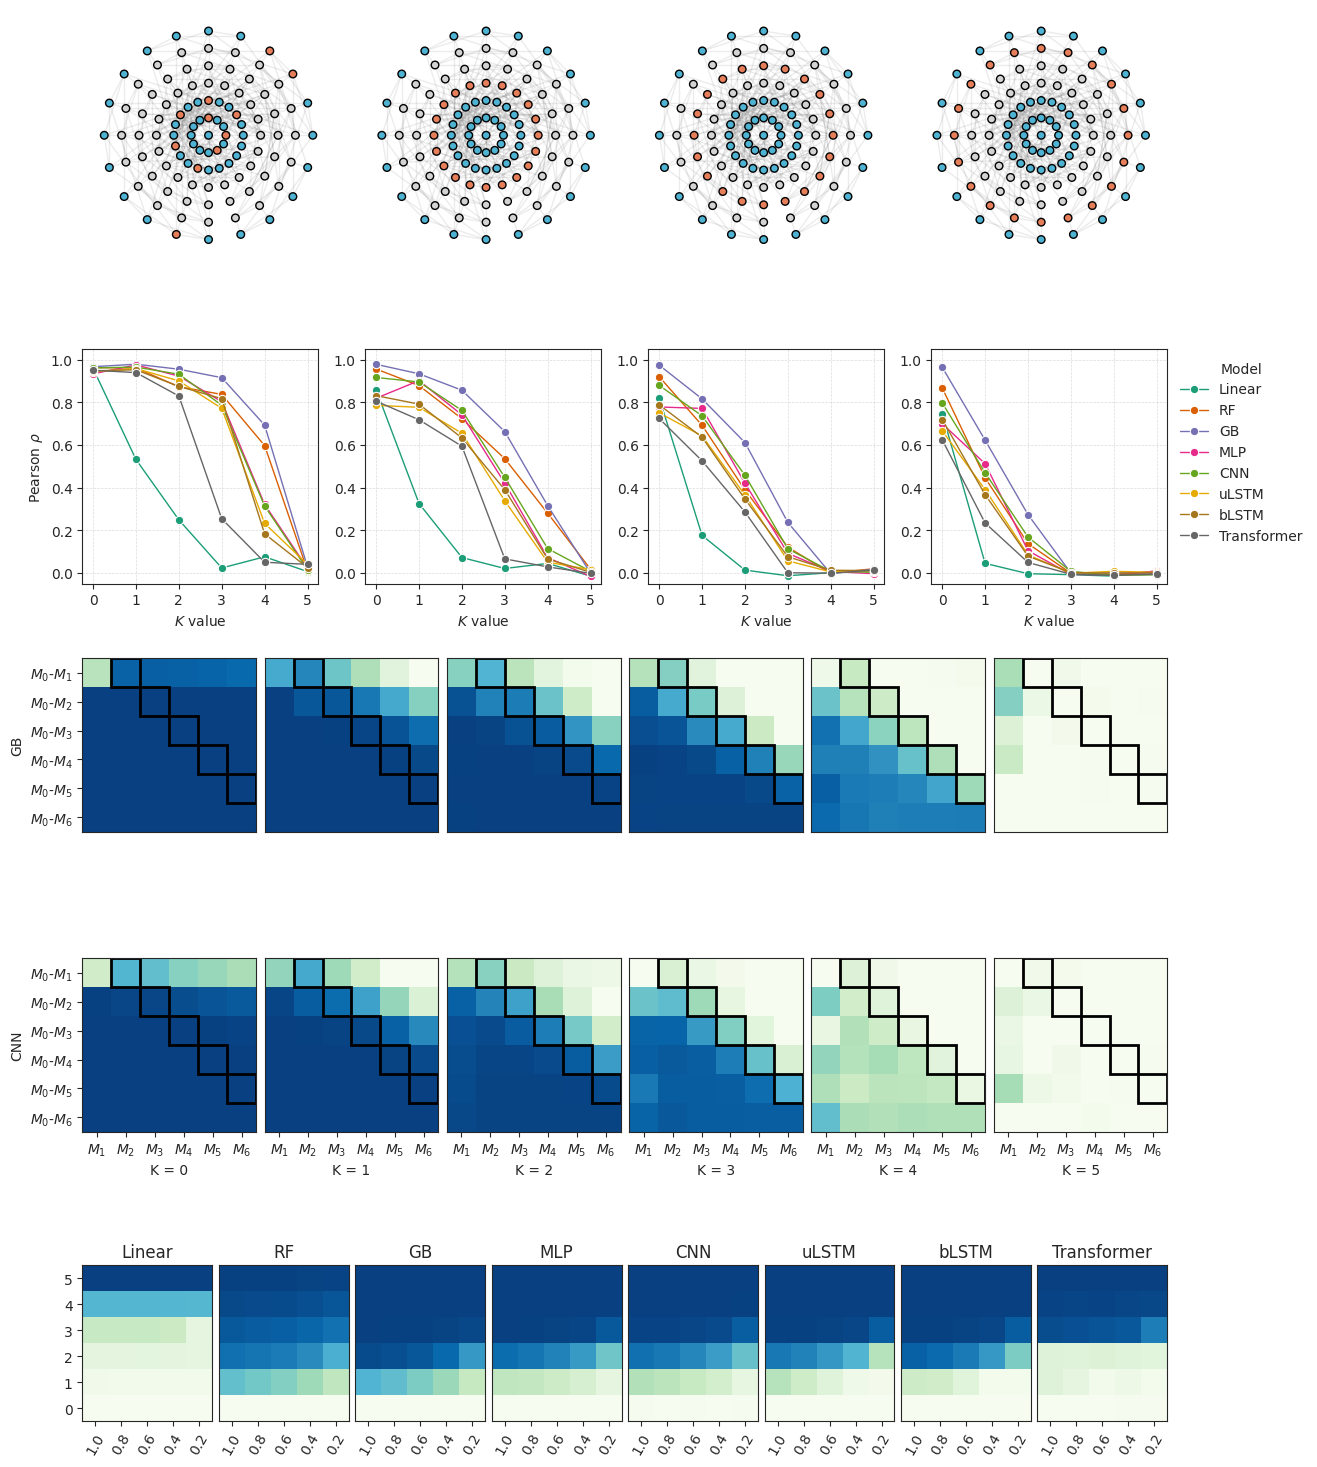

In [51]:


sns.set_style("ticks")

# Dynamically adjust figure size for better fitting
fig = plt.figure(figsize=(7*2, 10*2))

gs = gridspec.GridSpec(
    4, 1, figure=fig,
    wspace=0.05,   # Reduced whitespace between plots
    hspace=0.05,   # Reduced vertical whitespace
    height_ratios=[1, 0.6, 1.5, 0.7]  # Adjusted for better aspect balance
)

# ---- Row 0: Network Plots ----
row_0_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0], wspace=0.1)
row_0_axes = [fig.add_subplot(row_0_gs[i]) for i in range(4)]

for ax in row_0_axes:
    ax.set_aspect("equal")  # Ensures circular plots remain circular
    ax.axis("off")  # Hides unnecessary axes

# Drawing network plots
nx.draw_networkx_nodes(G_interp, pos_interp, node_color=signals_interp, **node_kwargs, ax=row_0_axes[0])
nx.draw_networkx_edges(G_interp, pos_interp, **edge_kwargs, ax=row_0_axes[0])

nx.draw_networkx_nodes(G_ext_1, pos_ext_1, node_color=signals_ext_1, **node_kwargs, ax=row_0_axes[1])
nx.draw_networkx_edges(G_ext_1, pos_ext_1, **edge_kwargs, ax=row_0_axes[1])

nx.draw_networkx_nodes(G_ext_2, pos_ext_2, node_color=signals_ext_2, **node_kwargs, ax=row_0_axes[2])
nx.draw_networkx_edges(G_ext_2, pos_ext_2, **edge_kwargs, ax=row_0_axes[2])

nx.draw_networkx_nodes(G_ext_3, pos_ext_3, node_color=signals_ext_3, **node_kwargs, ax=row_0_axes[3])
nx.draw_networkx_edges(G_ext_3, pos_ext_3, **edge_kwargs, ax=row_0_axes[3])


# ---- Row 1: Line Plots ----
row_1_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], wspace=0.2)
row_1_axes = [fig.add_subplot(row_1_gs[i]) for i in range(4)]

dark2_palette = sns.color_palette("Dark2", len(model_names)) 

plot_data = [nk_interp_idx, nk_extrap_single_idx, nk_extrap_double_idx, nk_extrap_triple_idx]

for idx, ax in enumerate(row_1_axes):
    sns.lineplot(
        data=plot_data[idx],
        x="K",
        y="Pearson_corr",
        hue="Model",
        marker="o",
        errorbar=None,
        linewidth=1,
        ax=ax,
        palette=dark2_palette
    )
    ax.get_legend().set_visible(False)
    ax.set_ylabel("")
    ax.set_xlabel(r"$K$ value")
    ax.set_xticks([0,1,2,3,4,5])
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_ylim(-0.05, 1.05)

row_1_axes[-1].legend(title="Model", bbox_to_anchor=(1, 1), loc="upper left", frameon=False)
row_1_axes[0].set_ylabel(r'Pearson $\rho$')


# ---- Row 2: Heatmaps ----
row_2_gs = gridspec.GridSpecFromSubplotSpec(2, 6, subplot_spec=gs[2], wspace=0.05, hspace=0.05)
row_2_axes = np.empty((2, 6), dtype=object)

for row in range(2): 
    for col in range(6):   
        row_2_axes[row, col] = fig.add_subplot(row_2_gs[row, col])

data_to_show = [pearson_results_mean[2], pearson_results_mean[4]]
models_to_show = [model_names[2], model_names[4]]

for i in range(2): 
    for j in range(6): 
        ax = row_2_axes[i, j]
        sns.heatmap(
            data_to_show[i][j],
            cmap="GnBu",
            vmin=0,
            vmax=1,
            ax=ax,
            square=True,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False
        )
        # Outline extrapolation regions
        for val in range(5):   
            rect = Rectangle((val + 1, val), 1, 1, edgecolor="black", facecolor="none", linewidth=2)
            ax.add_patch(rect)

        if j == 0:
            ax.set_yticks(np.arange(6)+0.5)
            ax.set_yticklabels([f'$M_{0}$-$M_{i + 1}$' for i in range(6)], rotation=0, fontsize=10)
        else:
            ax.set_yticks([])

        if i == 1:
            ax.set_xticks(np.arange(6)+0.5)
            ax.set_xticklabels([f'$M_{i + 1}$' for i in range(6)], rotation=0, fontsize=10)
        else:
            ax.set_xticks([])

        if j == 0:
            ax.set_ylabel(models_to_show[i])

        if i == 1:
            ax.set_xlabel(f"K = {j}")
            
        for _, spine in ax.spines.items():
            spine.set_visible(True)

# ---- Row 3: Additional Heatmaps ----
row_3_gs = gridspec.GridSpecFromSubplotSpec(1, 8, subplot_spec=gs[3], wspace=0.05)
row_3_axes = [fig.add_subplot(row_3_gs[i]) for i in range(8)]

for i in range(abl_prsn_res_means.shape[0]): 
    ax = row_3_axes[i]
    if i== 7: 
        cbar=True
    else: 
        cbar=False
    
    sns.heatmap(
        abl_prsn_res_means[i],
        cmap="GnBu",
        vmin=0,
        vmax=1,
        ax=ax,
        square=True,
        linewidths=0,
        cbar=False,
        xticklabels=False,
        yticklabels=False
    )
    ax.set_title(model_names[i])

    x_ticks = [1.0, 0.8, 0.6, 0.4, 0.2]
    ax.set_xticks(np.arange(5)+0.5)
    ax.set_xticklabels(x_ticks, rotation=60, fontsize=10)
    for _, spine in ax.spines.items():
            spine.set_visible(True)
    if i == 0:
        ax.set_yticks(np.arange(6) +0.5)
        ax.set_yticklabels(reversed(range(6)), rotation=0, fontsize=10)
plt.savefig('../figures/figure2_ALL_MS.svg')

# ---- Final Adjustments ----
#plt.show()



In [122]:
nk_extrap['pearson_r'].min()

np.float64(-0.916119705)